In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Import libraries
import keras
import keras.backend as K
from keras.models import Model
# Optimizer and regularization
from keras.regularizers import l2
from keras.losses import mean_squared_error, mean_absolute_error
# Keras layers
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Activation
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, MaxPooling2D, AveragePooling2D

# Model architecture
from resnet_1d_angles import *

Using TensorFlow backend.


## Loading the Dataset

In [2]:
# Load outputs/labels from file
outputs = np.genfromtxt("../data/angles/outputs.txt")
outputs[np.isnan(outputs)] = 0.0
outputs.shape

(43001, 2)

In [3]:
# Convert angles to sin/cos to remove angle periodicity
out = []
out.append(np.sin(outputs[:,0]))
out.append(np.cos(outputs[:,0]))
out.append(np.sin(outputs[:,1]))
out.append(np.cos(outputs[:,1]))
out = np.array(out).T
print(out.shape)

(43001, 4)


In [4]:
def get_ins(path = "../data/angles/input_aa.txt", pssm=None):
    """ Gets inputs from both AminoAcids (input_aa) and PSSM (input_pssm)"""
    # handles both files
    if pssm: path = "../data/angles/input_pssm.txt"
    # Opn file and read text
    with open(path, "r") as f:
        lines = f.read().split('\n')
    # Extract numeric data from text
    pre_ins = []
    for i,line in enumerate(lines):
        # Read each protein separately
        if line == "NEW":
            prot = []
            raw = lines[i+1:i+(17*2+1)]
            # Read each line as a vector + ensemble one-hot vectors as a matrix
            for r in raw:
                prot.append(np.array([float(x) for x in r.split(" ") if x != ""]))
            # Add prot to dataset
            pre_ins.append(np.array(prot))  
    
    return np.array(pre_ins)

In [5]:
# Get inputs data
aas = get_ins()
pssms = get_ins(pssm=True)
# Check that shapes match
print(aas.shape, pssms.shape)
# Concatenate input features
inputs = np.concatenate((aas[:, :, :20], pssms[:, :, :20], aas[:, :, 20:]), axis=2) 
inputs.shape

(43001, 34, 22) (43001, 34, 21)


(43001, 34, 42)

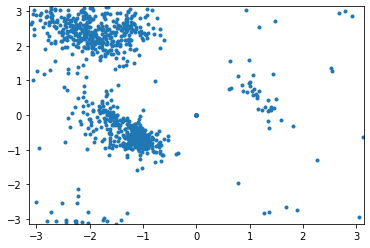

In [6]:
# Plot some angle sto make sure they follow a Ramachandran plot distribution
plt.scatter(outputs[:1000,0], outputs[:1000,1], marker=".")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

In [7]:
""" WE DON'T PREPROCESS INPUTS SINCE THEY'RE IN 0-1 RANGE"""
# Preprocess outputs (mean/std)
# mean = np.mean(inputs,axis=(0,1,2))
# std = np.std(inputs,axis=(0,1,2))
# pre_inputs = (inputs-mean)/(std+1e-7)

# print("Mean: ", mean)
# print("Std: ", std)

" WE DON'T PREPROCESS INPUTS SINCE THEY'RE IN 0-1 RANGE"

## Loading the model

In [8]:
# Using AMSGrad optimizer for speed 
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)
# Create model
model = resnet_v2(input_shape=(17*2,42), depth=20, num_classes=4, conv_first=True)
model.compile(optimizer=adam, loss=custom_mse_mae,
              metrics=["mean_absolute_error", "mean_squared_error"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34, 42)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 16)       2032        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 34, 16)       64          conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 34, 16)       0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Model training

In [9]:
# Separate data between training and testing
split = 38700
x_train, x_test = inputs[:split], inputs[split:]
y_train, y_test = out[:split], out[split:]

In [20]:
# Resnet (pre-act structure) with 34*42 columns as inputs - leaving a subset for validation
his = model.fit(x_train, y_train, epochs=5, batch_size=16, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Train on 38700 samples, validate on 4301 samples
Epoch 1/50
  368/38700 [..............................] - ETA: 50:55 - loss: 1.6636 - mean_absolute_error: 0.6253 - mean_squared_error: 0.5979

KeyboardInterrupt: 

### Making predictions

In [12]:
preds = model.predict(x_test)

In [13]:
# Get angle values from sin and cos
refactor = []
for pred in preds:
    angles = []
    phi_sin, phi_cos, psi_sin, psi_cos = pred[0], pred[1], pred[2], pred[3]
    
    #PHI
    angles.append(np.arctan2(phi_sin, phi_cos))
    #PSI
    angles.append(np.arctan2(psi_sin, psi_cos))

    refactor.append(angles)
    
refactor = np.array(refactor)
print(refactor.shape)

(4301, 2)


In [14]:
# Experimental debugging prints to validate the predictions
# print("PREDS: ", preds[40:50])
# print("OUT: ", out[40:50])
# print("----------------------------------------")
# print("REFACTOR: ", refactor[:10])
# print("OUTPUTS: ", outputs[:10])

In [15]:
# Set angle range in (-pi, pi)
refactor[refactor>np.pi] = np.pi
refactor[refactor<-np.pi] = -np.pi

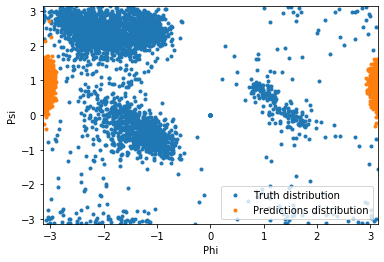

In [16]:
plt.scatter(outputs[split:,0], outputs[split:,1], marker=".")
plt.scatter(refactor[:,0], refactor[:,1], marker=".")
plt.legend(["Truth distribution", "Predictions distribution"], loc="lower right")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel("Phi")
plt.ylabel("Psi")
plt.show()

### Evaluate correlation between predictions and ground truth

In [17]:
# Calculate Perason coefficient btwn cosines of both angles (true values and predicted ones)
cos_phi = np.corrcoef(np.cos(refactor[:,0]), np.cos(outputs[split:,0]))
cos_psi = np.corrcoef(np.cos(refactor[:,1]), np.cos(outputs[split:,1]))

print("Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7")
print("Cos Phi: ", cos_phi[0,1])
print("Cos Psi: ", cos_psi[0,1])

Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7
Cos Phi:  -0.011969052020256225
Cos Psi:  -0.014847073430438812


In [18]:
model.save("resnet_1d_angles.h5")

# Done!

## Loading later

In [19]:
# from keras.models import load_model

In [20]:
# model = load_model("resnet_1d_angles.h5", custom_objects={'custom_mse_mae': custom_mse_mae})